In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv
/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv
/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv
/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv
/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv


In [33]:
# imports:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import nltk
plt.rcParams['figure.figsize'] = (12,6)
plt.style.use('fivethirtyeight')
from scipy import stats

#import dabl
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### 1. TASK
- The goal of this competition is to assess the **quality of summaries** written by students in grades 3-12. You'll build a model that evaluates how well a student represents the main idea and details of a source text, as well as the **clarity, precision, and fluency** of the language used in the summary. You'll have access to a collection of real student summaries to train your model.

- Your work will assist teachers in evaluating the quality of student work and also help learning platforms provide **immediate feedback** to students.

### Background
- Summary writing is an important skill for learners of all ages. Summarization enhances reading comprehension, particularly among second language learners and students with learning disabilities. Summary writing also promotes critical thinking, and it’s one of the most effective ways to improve writing abilities. However, students rarely have enough opportunities to practice this skill, as **evaluating and providing feedback on summaries can be a time-intensive process for teachers**. Innovative technology like **large language models (LLMs)** could help change this, as teachers could employ these solutions to assess summaries quickly.

- There have been advancements in the automated evaluation of student writing, including automated scoring for argumentative or narrative writing. However, these existing techniques don't translate well to summary writing. Evaluating summaries introduces an added layer of complexity, where models must consider **both the student writing and a single, longer source text.** Although there are a handful of current techniques for summary evaluation, these models have often focused on **assessing automatically-generated summaries** rather than real student writing, as there has historically been a lack of these types of datasets.

- Competition host CommonLit is a nonprofit education technology organization. CommonLit is dedicated to ensuring that all students, especially students in **Title I schools**, graduate with the reading, writing, communication, and problem-solving skills they need to be successful in college and beyond. The Learning Agency Lab, Vanderbilt University, and Georgia State University join CommonLit in this mission.

- As a result of your help to develop **summary scoring algorithms**, teachers and students alike will gain a valuable tool that promotes this fundamental skill. Students will have more opportunities to practice summarization, while simultaneously improving their **reading comprehension, critical thinking, and writing abilities.**

### Acknowledgments
- CommonLit, the Learning Agency Lab, Vanderbilt University, and Georgia State University would like to thank the Walton Family Foundation and Schmidt Futures for their support in making this work possible.

### 2. Dataset - EDA
The dataset comprises about 24,000 summaries written by students in grades 3-12 of passages on a variety of topics and genres. These summaries have been assigned scores for both content and wording. **The goal of the competition is to predict content and wording scores for summaries on unseen topics.**

File and Field Information

#### summaries_train.csv - Summaries in the training set.
- student_id - The ID of the student writer.
- prompt_id - The ID of the prompt which links to the prompt file.
- text - The full text of the student's summary.
- content - The content score for the summary. The first target.
- wording - The wording score for the summary. The second target.

#### summaries_test.csv - Summaries in the test set. Contains all fields above except content and wording.

#### prompts_train.csv - The four training set prompts. Each prompt comprises the complete summarization assignment given to students.
- prompt_id - The ID of the prompt which links to the summaries file.
- prompt_question - The specific question the students are asked to respond to.
- prompt_title - A short-hand title for the prompt.
- prompt_text - The full prompt text.

#### prompts_test.csv - The test set prompts. Contains the same fields as above. 
- The prompts here are only an example. The full test set has a large number of prompts. The train / public test / private test splits do not share any prompts.

#### sample_submission.csv - A submission file in the correct format. See the Evaluation page for details.
- Please note that this is a Code Competition. To help you author your submissions, we provide a some example data in summaries_test.csv and prompts_test.csv in the correct format. When your submission is scored, this example test data will be replaced with the full test set. The full test set comprises about 17,000 summaries from a large number of prompts.

In [34]:
prompts_train = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv')
print(f"Prompts Train shape: {prompts_train.shape}")
display(prompts_train.head())

Prompts Train shape: (4, 4)


,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [35]:
summaries_train =  pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv')
print(f"Summaries Train shape: {summaries_train.shape}")
display(summaries_train.head())

Summaries Train shape: (7165, 5)


,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [36]:
summaries_test =  pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv')
print(f"Summeries Test shape: {summaries_test.shape}")
display(summaries_test.head())


Summeries Test shape: (4, 3)


,student_id,prompt_id,text
0,000000ffffff,abc123,Example text 1
1,111111eeeeee,def789,Example text 2
2,222222cccccc,abc123,Example text 3
3,333333dddddd,def789,Example text 4


In [37]:
prompts_test =  pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv')
print(f"Prompts Test shape: {prompts_test.shape}")
display(prompts_test.head())

Prompts Test shape: (2, 4)


,prompt_id,prompt_question,prompt_title,prompt_text
0,abc123,Summarize...,Example Title 1,Heading\nText...
1,def789,Summarize...,Example Title 2,Heading\nText...


In [38]:
sample_submission =  pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv')
display(sample_submission)

,student_id,content,wording
0,000000ffffff,0.0,0.0
1,111111eeeeee,0.0,0.0
2,222222cccccc,0.0,0.0
3,333333dddddd,0.0,0.0


### Combining Prompts and Summary


In [39]:
train = pd.merge(prompts_train, summaries_train, how = 'inner', on = 'prompt_id')
test = pd.merge(prompts_test, summaries_test, how = 'inner', on = 'prompt_id')
print(f"Train Dataset shape: {train.shape}\n")
display(train.head())
print(f"Test Dataset shape: {test.shape}\n")
display(test.head())

Train Dataset shape: (7165, 8)



,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,content,wording
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00791789cc1f,1 element of an ideal tragedy is that it shoul...,-0.210614,-0.471415
1,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,0086ef22de8f,The three elements of an ideal tragedy are: H...,-0.970237,-0.417058
2,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,0094589c7a22,Aristotle states that an ideal tragedy should ...,-0.387791,-0.584181
3,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00cd5736026a,One element of an Ideal tragedy is having a co...,0.088882,-0.594710
4,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00d98b8ff756,The 3 ideal of tragedy is how complex you need...,-0.687288,-0.460886


Test Dataset shape: (4, 6)



,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text
0,abc123,Summarize...,Example Title 1,Heading\nText...,000000ffffff,Example text 1
1,abc123,Summarize...,Example Title 1,Heading\nText...,222222cccccc,Example text 3
2,def789,Summarize...,Example Title 2,Heading\nText...,111111eeeeee,Example text 2
3,def789,Summarize...,Example Title 2,Heading\nText...,333333dddddd,Example text 4


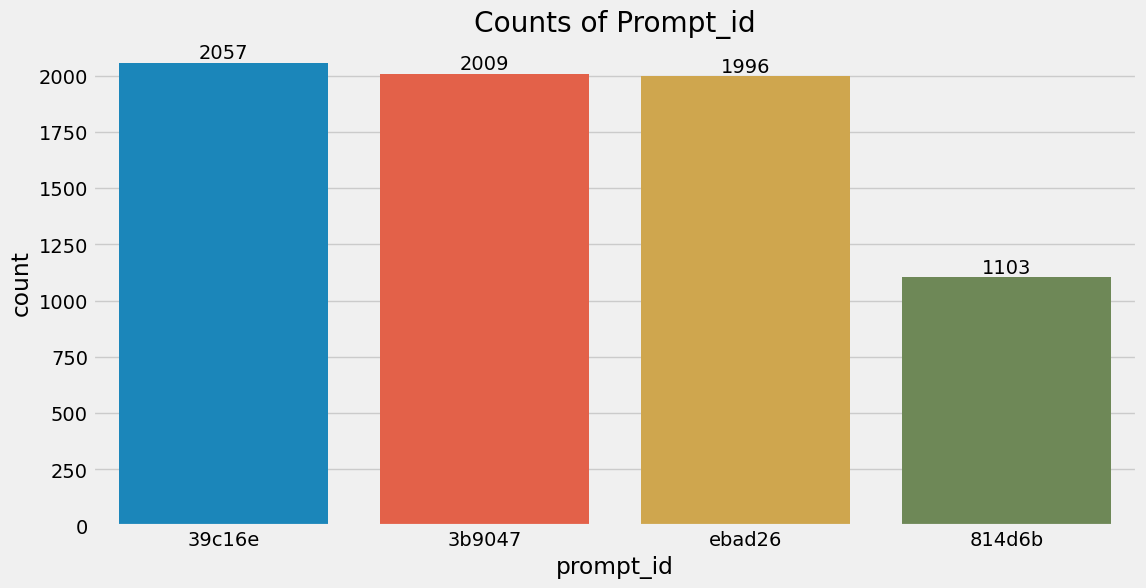

In [40]:
# Calculate the value counts of "prompt_id" and sort in descending order
counts = train['prompt_id'].value_counts().sort_values(ascending=False)

# Create a countplot (bar plot) using Seaborn with the sorted data
sns.countplot(x='prompt_id', data=train, order=counts.index)

# Add counts above each bar
for p in plt.gca().patches:
    plt.gca().annotate(f'\n{round(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.title("Counts of Prompt_id")
plt.show()

In [41]:
train['prompt_id_question'] = train['prompt_id'] + ': ' + train['prompt_question']
for i, c in enumerate(train['prompt_id_question'].unique()): 
    print(c)

39c16e: Summarize at least 3 elements of an ideal tragedy, as described by Aristotle.
3b9047: In complete sentences, summarize the structure of the ancient Egyptian system of government. How were different social classes involved in this government? Cite evidence from the text.
814d6b: Summarize how the Third Wave developed over such a short period of time and why the experiment was ended.
ebad26: Summarize the various ways the factory would use or cover up spoiled meat. Cite evidence in your answer.


In [42]:
# Display summary statistics
train.describe()

,content,wording
count,7165.000000,7165.000000
mean,-0.014853,-0.063072
std,1.043569,1.036048
min,-1.729859,-1.962614
25%,-0.799545,-0.872720
50%,-0.093814,-0.081769
75%,0.499660,0.503833
max,3.900326,4.310693


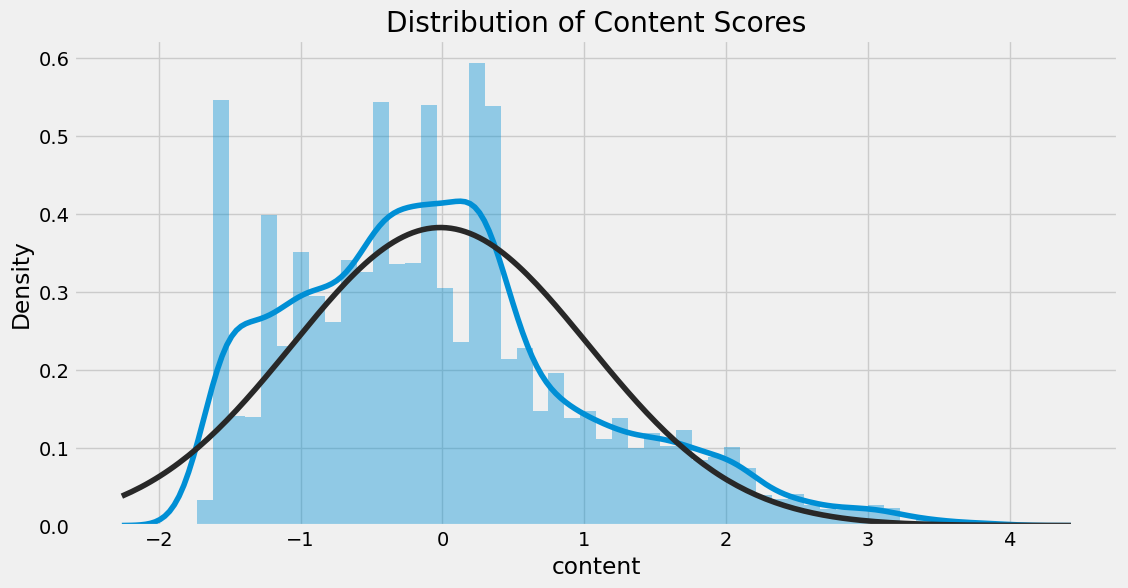

In [43]:
sns.distplot(train.content,bins= 50,kde=True,fit=stats.norm)
plt.title("Distribution of Content Scores")
plt.show()

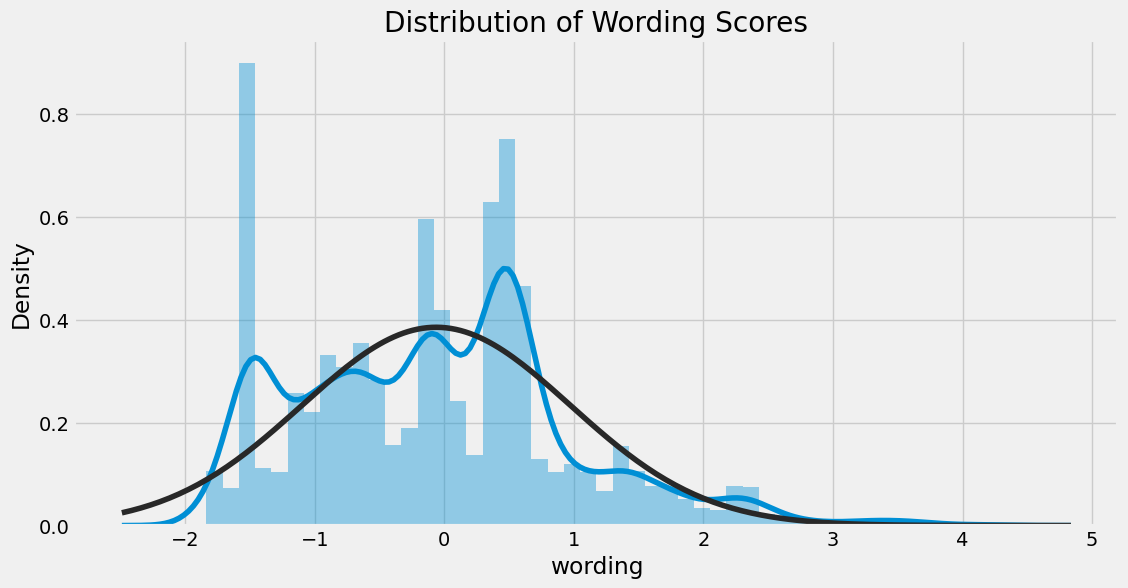

In [44]:
sns.distplot(train.wording,bins =50, kde=True,fit=stats.norm)
plt.title("Distribution of Wording Scores")
plt.show()

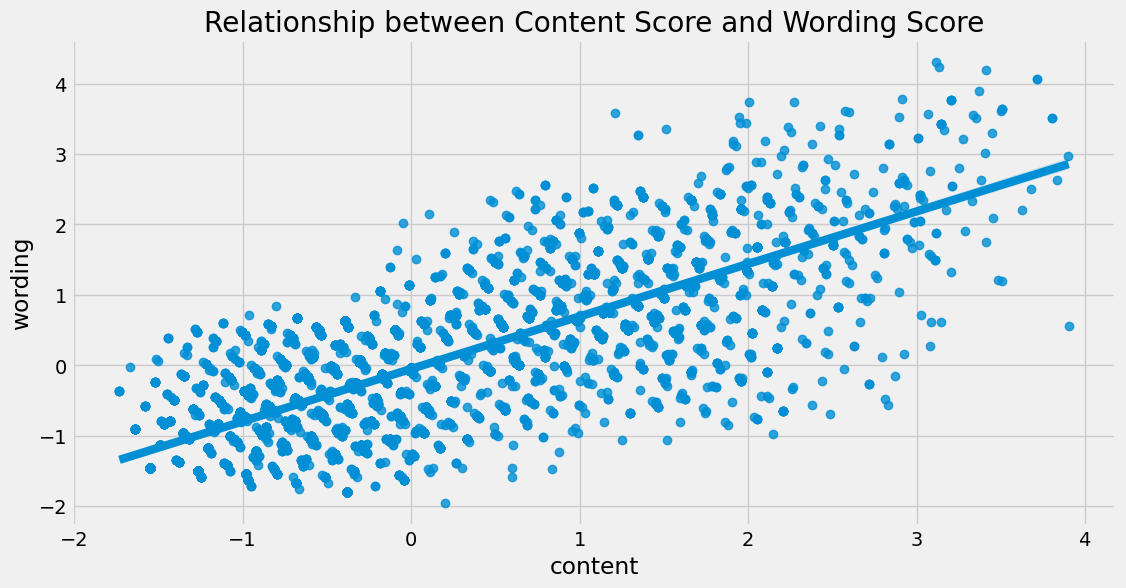

In [45]:
sns.regplot(x=train.content, y=train.wording)
plt.title("Relationship between Content Score and Wording Score")
plt.show()

#### Try Model 1:  Linear Regression  -- Baseline (text)

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [47]:
# Split the data into training and validation sets
train_set, val_set = train_test_split(train, test_size=0.2, random_state=42)



- Tokenization is the process of breaking down a piece of text (e.g., a sentence or a paragraph) into smaller units called tokens. These tokens can be individual words, subwords, characters, or even smaller units, depending on the tokenizer used. This can be done by various ways such as **Bag of Words, Word2Vec, Term Frequency-Inverse Document Frequency (TD-IDF), Global Vectors for Word Representation (GLOVE)**


In [48]:
# Prepare the text data for training
vectorizer = TfidfVectorizer()
train_text = vectorizer.fit_transform(train_set['text'])
val_text = vectorizer.transform(val_set['text'])

In [49]:
# Prepare the target variables
train_content = train_set['content']
train_wording = train_set['wording']
val_content = val_set['content']
val_wording = val_set['wording']

In [50]:
# Train the content score model
content_model = LinearRegression()
content_model.fit(train_text, train_content)

LinearRegression()

In [51]:
# Train the wording score model
wording_model = LinearRegression()
wording_model.fit(train_text, train_wording)

LinearRegression()

In [52]:
# Make predictions on the validation set
val_content_preds = content_model.predict(val_text)
val_wording_preds = wording_model.predict(val_text)

In [53]:
# Evaluate the model using mean squared error
content_rmse = mean_squared_error(val_content, val_content_preds, squared=False)
wording_rmse = mean_squared_error(val_wording, val_wording_preds, squared=False)
print(f"Content RMSE: {content_rmse}")
print(f"Wording RMSE: {wording_rmse}")

Content RMSE: 13.557967153733845
Wording RMSE: 9.550114231348777


In [54]:
test_df = train.head()
test_df

,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,content,wording,prompt_id_question
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00791789cc1f,1 element of an ideal tragedy is that it shoul...,-0.210614,-0.471415,39c16e: Summarize at least 3 elements of an id...
1,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,0086ef22de8f,The three elements of an ideal tragedy are: H...,-0.970237,-0.417058,39c16e: Summarize at least 3 elements of an id...
2,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,0094589c7a22,Aristotle states that an ideal tragedy should ...,-0.387791,-0.584181,39c16e: Summarize at least 3 elements of an id...
3,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00cd5736026a,One element of an Ideal tragedy is having a co...,0.088882,-0.594710,39c16e: Summarize at least 3 elements of an id...
4,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00d98b8ff756,The 3 ideal of tragedy is how complex you need...,-0.687288,-0.460886,39c16e: Summarize at least 3 elements of an id...


In [55]:
# Prepare the text data for testing
test_text = vectorizer.transform(test['text'])
# Make predictions on the test set
test_content_preds = content_model.predict(test_text)
test_wording_preds = wording_model.predict(test_text)

### Submission

In [56]:
test.text[0]

'Example text 1'

In [57]:
# Create the submission file
submission = pd.DataFrame({
    'student_id': test['student_id'],
    'content': test_content_preds,
    'wording': test_wording_preds
})
submission.to_csv('submission.csv', index=False)
display(submission)

,student_id,content,wording
0,000000ffffff,0.235874,2.49818
1,222222cccccc,0.235874,2.49818
2,111111eeeeee,0.235874,2.49818
3,333333dddddd,0.235874,2.49818


### Model 2: LinearRegression - All



In [58]:
train.columns

Index(['prompt_id', 'prompt_question', 'prompt_title', 'prompt_text', 'student_id', 'text', 'content', 'wording', 'prompt_id_question'], dtype='object')

In [59]:
# Prepare the text data for training
train['prompt_question_title_text_summary'] = train['prompt_question']+train['prompt_title'] + train['prompt_text'] + train['text']

# Split the data into training and validation sets
train_set, val_set = train_test_split(train, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()

train_text = vectorizer.fit_transform(train_set['prompt_question_title_text_summary'])
val_text = vectorizer.transform(val_set['prompt_question_title_text_summary'])


In [60]:
# Prepare the target variables
train_content = train_set['content']
train_wording = train_set['wording']
val_content = val_set['content']
val_wording = val_set['wording']

In [61]:
# Train the content score model
content_model = LinearRegression()
content_model.fit(train_text, train_content)

LinearRegression()

In [62]:
# Train the wording score model
wording_model = LinearRegression()
wording_model.fit(train_text, train_wording)

LinearRegression()

In [63]:
# Evaluate the model using mean squared error
content_rmse = mean_squared_error(val_content, val_content_preds, squared=False)
wording_rmse = mean_squared_error(val_wording, val_wording_preds, squared=False)
print(f"Content RMSE: {content_rmse}")
print(f"Wording RMSE: {wording_rmse}")

Content RMSE: 13.557967153733845
Wording RMSE: 9.550114231348777


In [64]:
test.columns

Index(['prompt_id', 'prompt_question', 'prompt_title', 'prompt_text', 'student_id', 'text'], dtype='object')

In [65]:
# Prepare the text data for testing
test_text = vectorizer.transform(test['prompt_question']+test['prompt_title'] + test['prompt_text'] + test['text'])
# Make predictions on the test set
test_content_preds = content_model.predict(test_text)
test_wording_preds = wording_model.predict(test_text)

In [66]:
# Create the submission file
submission = pd.DataFrame({
    'student_id': test['student_id'],
    'content': test_content_preds,
    'wording': test_wording_preds
})
submission.to_csv('submission.csv', index=False)
display(submission)

,student_id,content,wording
0,000000ffffff,561.138859,4.321089
1,222222cccccc,561.138859,4.321089
2,111111eeeeee,561.138859,4.321089
3,333333dddddd,561.138859,4.321089


### Model 2:
### 3. Tokenizatin


- **RoBERTa** is a popular pre-trained language model based on the Transformer architecture, and its tokenizer is designed to convert raw text into a sequence of tokens that can be fed into the RoBERTa model for various natural language processing tasks. In the context of RoBERTa, the tokenization process involves the following steps:

**Word Splitting**: The input text is split into words or subwords. RoBERTa, like other BERT-based models, uses the WordPiece tokenizer, which further breaks down words into subwords when necessary. This helps handle out-of-vocabulary words and reduces the vocabulary size.

**Token Encoding**: Each word or subword is then mapped to an integer token ID using a vocabulary. The tokenizer maintains a mapping between words (or subwords) and unique integer token IDs.

**Special Tokens**: The tokenizer also adds special tokens to the input sequence, such as the [CLS] token (used for classification tasks) and the [SEP] token (used to separate different segments of the input).

**Padding and Truncation**: To ensure all input sequences have the same length, the tokenizer may add padding tokens (usually [PAD]) to shorter sequences and truncate longer sequences.

**Attention Masking**: An attention mask is created to tell the model which tokens are actual input tokens and which are padding tokens. This helps the model ignore the padding tokens during training and inference.

- After tokenization, the resulting token IDs and attention masks are used as input to the RoBERTa model for various tasks like text classification, question answering, or language modeling.



In [67]:
from transformers import RobertaTokenizer

# Initialize the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

tokenizer

RobertaTokenizer(name_or_path='roberta-base', vocab_size=50265, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)}, clean_up_tokenization_spaces=True)

In [68]:
# for text
print(train.text[0],"\n")
tokenizer(train.text[0])

1 element of an ideal tragedy is that it should be arranged on a complex plan.  Another element of an ideal tragedy is that it should only have one main issue. The last element of an ideal tragedy is that it should have a double thread plot and an opposite catastrophe for both good and bad. 



{'input_ids': [0, 134, 7510, 9, 41, 5631, 6906, 16, 14, 24, 197, 28, 12121, 15, 10, 2632, 563, 4, 1437, 2044, 7510, 9, 41, 5631, 6906, 16, 14, 24, 197, 129, 33, 65, 1049, 696, 4, 20, 94, 7510, 9, 41, 5631, 6906, 16, 14, 24, 197, 33, 10, 1457, 15019, 6197, 8, 41, 5483, 21421, 13, 258, 205, 8, 1099, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [69]:
# for prompt text
print(train.prompt_text[0],"\n")
tokenizer(train.prompt_text[0])

Token indices sequence length is longer than the specified maximum sequence length for this model (760 > 512). Running this sequence through the model will result in indexing errors


Chapter 13 
As the sequel to what has already been said, we must proceed to consider what the poet should aim at, and what he should avoid, in constructing his plots; and by what means the specific effect of Tragedy will be produced. 
A perfect tragedy should, as we have seen, be arranged not on the simple but on the complex plan. It should, moreover, imitate actions which excite pity and fear, this being the distinctive mark of tragic imitation. It follows plainly, in the first place, that the change of fortune presented must not be the spectacle of a virtuous man brought from prosperity to adversity: for this moves neither pity nor fear; it merely shocks us. Nor, again, that of a bad man passing from adversity to prosperity: for nothing can be more alien to the spirit of Tragedy; it possesses no single tragic quality; it neither satisfies the moral sense nor calls forth pity or fear. Nor, again, should the downfall of the utter villain be exhibited. A plot of this kind would, doubtle

{'input_ids': [0, 45642, 508, 1437, 50121, 50118, 1620, 5, 12123, 7, 99, 34, 416, 57, 26, 6, 52, 531, 9073, 7, 1701, 99, 5, 16893, 197, 4374, 23, 6, 8, 99, 37, 197, 1877, 6, 11, 25886, 39, 21258, 131, 8, 30, 99, 839, 5, 2167, 1683, 9, 2393, 4628, 219, 40, 28, 2622, 4, 1437, 50121, 50118, 250, 1969, 6906, 197, 6, 25, 52, 33, 450, 6, 28, 12121, 45, 15, 5, 2007, 53, 15, 5, 2632, 563, 4, 85, 197, 6, 41353, 6, 41379, 2163, 61, 12562, 1459, 31373, 8, 2490, 6, 42, 145, 5, 16141, 2458, 9, 8805, 40059, 4, 85, 3905, 32907, 6, 11, 5, 78, 317, 6, 14, 5, 464, 9, 13016, 2633, 531, 45, 28, 5, 20286, 9, 10, 41890, 313, 1146, 31, 12536, 7, 22837, 35, 13, 42, 3136, 5063, 31373, 3486, 2490, 131, 24, 8315, 23485, 201, 4, 6567, 6, 456, 6, 14, 9, 10, 1099, 313, 3133, 31, 22837, 7, 12536, 35, 13, 1085, 64, 28, 55, 13058, 7, 5, 4780, 9, 2393, 4628, 219, 131, 24, 28011, 117, 881, 8805, 1318, 131, 24, 5063, 43578, 5, 7654, 1472, 3486, 1519, 7264, 31373, 50, 2490, 4, 6567, 6, 456, 6, 197, 5, 27849, 9, 5, 18672, 

In [70]:
# Find the maximum length of text in the 'text'
max_length = train['text'].apply(lambda x: len(x)).max()

# Print the maximum length
print("Maximum length of text:", max_length)

Maximum length of text: 3940


In [71]:
# Find the maximum length of text in the 'prompt_text'
max_length_p = train['prompt_text'].apply(lambda x: len(x)).max()

# Print the maximum length
print("Maximum length of promp_text:", max_length_p)

Maximum length of promp_text: 5136


In [72]:
train.columns

Index(['prompt_id', 'prompt_question', 'prompt_title', 'prompt_text', 'student_id', 'text', 'content', 'wording', 'prompt_id_question', 'prompt_question_title_text_summary'], dtype='object')

In [73]:
# Find the maximum length of text in the 'prompt_quesiton'
max_length_q = train['prompt_question'].apply(lambda x: len(x)).max()

# Print the maximum length
print("Maximum length of prompt_question:", max_length_q)

Maximum length of prompt_question: 184


In [74]:
# Find the maximum length of text in the 'prompt_quesiton'
max_length_t = train['prompt_title'].apply(lambda x: len(x)).max()

# Print the maximum length
print("Maximum length of prompt_title:", max_length_t)

Maximum length of prompt_title: 25


In [75]:
train['prompt_question_title_text_summary'] = train['prompt_question']+train['prompt_title'] + train['prompt_text'] + train['text']
train['prompt_question_title_text_summary'][0]


'Summarize at least 3 elements of an ideal tragedy, as described by Aristotle.On TragedyChapter 13 \r\nAs the sequel to what has already been said, we must proceed to consider what the poet should aim at, and what he should avoid, in constructing his plots; and by what means the specific effect of Tragedy will be produced. \r\nA perfect tragedy should, as we have seen, be arranged not on the simple but on the complex plan. It should, moreover, imitate actions which excite pity and fear, this being the distinctive mark of tragic imitation. It follows plainly, in the first place, that the change of fortune presented must not be the spectacle of a virtuous man brought from prosperity to adversity: for this moves neither pity nor fear; it merely shocks us. Nor, again, that of a bad man passing from adversity to prosperity: for nothing can be more alien to the spirit of Tragedy; it possesses no single tragic quality; it neither satisfies the moral sense nor calls forth pity or fear. Nor, ag

In [76]:
# Find the maximum length of text in the 'prompt_quesiton'
max_length_s = train['prompt_question_title_text_summary'].apply(lambda x: len(x)).max()

# Print the maximum length
print("Maximum length of prompt_question_title_text_summary:", max_length_s)

Maximum length of prompt_question_title_text_summary: 8038


In [77]:
tokenizer.model_max_length = 8100

# for prompt text
print(train.prompt_text[0],"\n")
tokenizer(train.prompt_text[0])

Chapter 13 
As the sequel to what has already been said, we must proceed to consider what the poet should aim at, and what he should avoid, in constructing his plots; and by what means the specific effect of Tragedy will be produced. 
A perfect tragedy should, as we have seen, be arranged not on the simple but on the complex plan. It should, moreover, imitate actions which excite pity and fear, this being the distinctive mark of tragic imitation. It follows plainly, in the first place, that the change of fortune presented must not be the spectacle of a virtuous man brought from prosperity to adversity: for this moves neither pity nor fear; it merely shocks us. Nor, again, that of a bad man passing from adversity to prosperity: for nothing can be more alien to the spirit of Tragedy; it possesses no single tragic quality; it neither satisfies the moral sense nor calls forth pity or fear. Nor, again, should the downfall of the utter villain be exhibited. A plot of this kind would, doubtle

{'input_ids': [0, 45642, 508, 1437, 50121, 50118, 1620, 5, 12123, 7, 99, 34, 416, 57, 26, 6, 52, 531, 9073, 7, 1701, 99, 5, 16893, 197, 4374, 23, 6, 8, 99, 37, 197, 1877, 6, 11, 25886, 39, 21258, 131, 8, 30, 99, 839, 5, 2167, 1683, 9, 2393, 4628, 219, 40, 28, 2622, 4, 1437, 50121, 50118, 250, 1969, 6906, 197, 6, 25, 52, 33, 450, 6, 28, 12121, 45, 15, 5, 2007, 53, 15, 5, 2632, 563, 4, 85, 197, 6, 41353, 6, 41379, 2163, 61, 12562, 1459, 31373, 8, 2490, 6, 42, 145, 5, 16141, 2458, 9, 8805, 40059, 4, 85, 3905, 32907, 6, 11, 5, 78, 317, 6, 14, 5, 464, 9, 13016, 2633, 531, 45, 28, 5, 20286, 9, 10, 41890, 313, 1146, 31, 12536, 7, 22837, 35, 13, 42, 3136, 5063, 31373, 3486, 2490, 131, 24, 8315, 23485, 201, 4, 6567, 6, 456, 6, 14, 9, 10, 1099, 313, 3133, 31, 22837, 7, 12536, 35, 13, 1085, 64, 28, 55, 13058, 7, 5, 4780, 9, 2393, 4628, 219, 131, 24, 28011, 117, 881, 8805, 1318, 131, 24, 5063, 43578, 5, 7654, 1472, 3486, 1519, 7264, 31373, 50, 2490, 4, 6567, 6, 456, 6, 197, 5, 27849, 9, 5, 18672, 

In [79]:
 import tqdm

In [80]:
tokens = np.empty(shape = train.shape[0] , dtype = np.ndarray)

for index in tqdm.tqdm(range(train.shape[0]) , total = train.shape[0]):
                       
    stri = ""
    
    for columns in ["prompt_question" , "prompt_title" , "prompt_text" , "text"]:
        
        stri += "\n\n" + str(train[columns][index])
        
    tokens[index] = tokenizer(stri , return_tensors = 'np')["input_ids"]

100%|██████████| 7165/7165 [01:13<00:00, 97.13it/s] 


In [81]:
np.save("/kaggle/working/Sample Tokens" , tokens)

In [82]:
train.head()

,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,content,wording,prompt_id_question,prompt_question_title_text_summary
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00791789cc1f,1 element of an ideal tragedy is that it shoul...,-0.210614,-0.471415,39c16e: Summarize at least 3 elements of an id...,Summarize at least 3 elements of an ideal trag...
1,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,0086ef22de8f,The three elements of an ideal tragedy are: H...,-0.970237,-0.417058,39c16e: Summarize at least 3 elements of an id...,Summarize at least 3 elements of an ideal trag...
2,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,0094589c7a22,Aristotle states that an ideal tragedy should ...,-0.387791,-0.584181,39c16e: Summarize at least 3 elements of an id...,Summarize at least 3 elements of an ideal trag...
3,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00cd5736026a,One element of an Ideal tragedy is having a co...,0.088882,-0.594710,39c16e: Summarize at least 3 elements of an id...,Summarize at least 3 elements of an ideal trag...
4,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00d98b8ff756,The 3 ideal of tragedy is how complex you need...,-0.687288,-0.460886,39c16e: Summarize at least 3 elements of an id...,Summarize at least 3 elements of an ideal trag...


- **LongformerTokenizer** is a tokenizer provided by the Hugging Face Transformers library specifically designed for the Longformer model. The Longformer model is a transformer-based model that is designed to efficiently handle long-range dependencies in text, making it well-suited for tasks involving longer sequences such as document-level text processing.

- The LongformerTokenizer tokenizes input text into a format suitable for input to the Longformer model. It breaks down the input text into individual tokens, converts them to their corresponding integer IDs, and performs other preprocessing steps necessary for transformer models. The tokenizer also handles special tokens like [CLS], [SEP], and [PAD], which are used in transformer-based models for various purposes.

- The LongformerTokenizer is initialized from a pre-trained Longformer model, and it is responsible for ensuring that the input text is tokenized consistently with the model's vocabulary. You can choose from various pre-trained Longformer models with different architectures and tokenization configurations.



In [85]:
from transformers import LongformerTokenizer

# Load the Longformer tokenizer
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")

In [86]:
# for prompt text
print(train.prompt_text[0],"\n")
tokenizer(train.prompt_text[0])

Chapter 13 
As the sequel to what has already been said, we must proceed to consider what the poet should aim at, and what he should avoid, in constructing his plots; and by what means the specific effect of Tragedy will be produced. 
A perfect tragedy should, as we have seen, be arranged not on the simple but on the complex plan. It should, moreover, imitate actions which excite pity and fear, this being the distinctive mark of tragic imitation. It follows plainly, in the first place, that the change of fortune presented must not be the spectacle of a virtuous man brought from prosperity to adversity: for this moves neither pity nor fear; it merely shocks us. Nor, again, that of a bad man passing from adversity to prosperity: for nothing can be more alien to the spirit of Tragedy; it possesses no single tragic quality; it neither satisfies the moral sense nor calls forth pity or fear. Nor, again, should the downfall of the utter villain be exhibited. A plot of this kind would, doubtle

{'input_ids': [0, 45642, 508, 1437, 50121, 50118, 1620, 5, 12123, 7, 99, 34, 416, 57, 26, 6, 52, 531, 9073, 7, 1701, 99, 5, 16893, 197, 4374, 23, 6, 8, 99, 37, 197, 1877, 6, 11, 25886, 39, 21258, 131, 8, 30, 99, 839, 5, 2167, 1683, 9, 2393, 4628, 219, 40, 28, 2622, 4, 1437, 50121, 50118, 250, 1969, 6906, 197, 6, 25, 52, 33, 450, 6, 28, 12121, 45, 15, 5, 2007, 53, 15, 5, 2632, 563, 4, 85, 197, 6, 41353, 6, 41379, 2163, 61, 12562, 1459, 31373, 8, 2490, 6, 42, 145, 5, 16141, 2458, 9, 8805, 40059, 4, 85, 3905, 32907, 6, 11, 5, 78, 317, 6, 14, 5, 464, 9, 13016, 2633, 531, 45, 28, 5, 20286, 9, 10, 41890, 313, 1146, 31, 12536, 7, 22837, 35, 13, 42, 3136, 5063, 31373, 3486, 2490, 131, 24, 8315, 23485, 201, 4, 6567, 6, 456, 6, 14, 9, 10, 1099, 313, 3133, 31, 22837, 7, 12536, 35, 13, 1085, 64, 28, 55, 13058, 7, 5, 4780, 9, 2393, 4628, 219, 131, 24, 28011, 117, 881, 8805, 1318, 131, 24, 5063, 43578, 5, 7654, 1472, 3486, 1519, 7264, 31373, 50, 2490, 4, 6567, 6, 456, 6, 197, 5, 27849, 9, 5, 18672, 

In [87]:
# Define a function to tokenize the text
def tokenize_text(text):
    return tokenizer(text, truncation=True, padding='max_length', max_length=8100, return_tensors='pt')['input_ids']

# Apply the tokenizer function to the 'text_column' of the DataFrame
train['tokenized_text'] = train['text'].apply(tokenize_text)


In [ ]:
train['tokenized_text'][0]

### RoBERTa Model
- RoBERTa (A Robustly Optimized BERT Pretraining Approach) is a language representation model introduced by Facebook AI in 2019. It builds upon the original BERT (Bidirectional Encoder Representations from Transformers) model, but with several modifications and optimizations, leading to significant improvements in performance.

**The main differences between RoBERTa and BERT are as follows:**

- Training data and objectives: RoBERTa is trained on a much larger dataset and for a more extended period compared to BERT. BERT was pre-trained on BooksCorpus (800M words) and English Wikipedia (2.5B words) for 1 million steps. In contrast, RoBERTa is trained on the concatenation of BooksCorpus (16GB) and CC-News (76GB) with 160GB of text, and it is trained for 500,000 steps. Additionally, RoBERTa uses a dynamic masking strategy, where the masking pattern is randomly chosen for each training epoch, while BERT used a fixed masking pattern.

- Larger batch size: RoBERTa employs a larger batch size during pretraining, which helps improve the model's performance.

- Removing the next sentence prediction (NSP) task: BERT utilized the NSP task during pretraining, which involved predicting whether two sentences appeared consecutively in the training data. RoBERTa, however, found that this task didn't contribute much to the model's performance. Hence, it discards the NSP task and only focuses on masked language modeling (MLM).

- Hyperparameter tuning: RoBERTa uses an extensive hyperparameter search to identify the best set of hyperparameters, whereas BERT's hyperparameters were not as thoroughly optimized.

- These modifications allow RoBERTa to achieve better results than BERT across various natural language processing (NLP) tasks and benchmarks.

- Like BERT, RoBERTa is based on the Transformer architecture, which utilizes self-attention mechanisms to capture contextual relationships between words in a sentence. The pretraining process involves predicting masked words in sentences, where some tokens are randomly masked out, and the model learns to predict the original tokens based on the surrounding context. After pretraining, RoBERTa can be fine-tuned for specific downstream NLP tasks, such as sentiment analysis, question answering, text classification, and more.


In [88]:
from torch.utils.data import Dataset , DataLoader
import torch

In [89]:
class DataSet(Dataset):
    
    def __init__(self , target = "content"):
        
        train = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv").merge(
            pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv") , on = "prompt_id")
        
        self.embeds = np.load("/kaggle/working/Sample Tokens.npy" , allow_pickle = True)
        
        self.content = train["content"]
        self.wording = train["wording"]
        
        self.target = target

In [90]:
class DataSet(Dataset):
    
    def __init__(self , target = "content"):
        
        train = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv").merge(
            pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv") , on = "prompt_id")
        
        self.embeds = np.load("/kaggle/working/Sample Tokens.npy" , allow_pickle = True).tolist()
        
        self.content = train["content"]
        self.wording = train["wording"]
        
        self.target = target
        
    def __len__(self): return self.content.shape[0]
    
    def __getitem__(self , index):
        
        r_embeds = torch.tensor(self.embeds[index] , dtype = torch.long)
        
        if self.target == "content": r_targets = torch.tensor(self.content[index] , dtype = torch.float32)
        if self.target == "wording": r_targets = torch.tensor(self.wording[index] , dtype = torch.float32)
            
        return r_embeds , r_targets

In [91]:
train_dataset = DataSet(target = "content")

train_dataloader = DataLoader(train_dataset , shuffle = True , batch_size = 1)

In [92]:
from transformers import AutoModel
import torch.nn as nn

In [93]:
# Instantiate the model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
    
        self.r_model = AutoModel.from_pretrained("roberta-base")

        self.ln = nn.LayerNorm(768)
        self.out = nn.Linear(768, 1)
    
    def forward(self, inputs):
        emb = self.r_model(**inputs).last_hidden_state
        emb = torch.mean(emb, axis=1)
        
        output = self.ln(emb)
        output = self.out(output)
        
        return output

model = Model()

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    
    for batch in train_dataloader:
        inputs, labels = batch
        inputs = {key: value.to(device) for key, value in inputs.items()}  # Convert tensors to device
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.view(-1), labels.float())  # BCEWithLogitsLoss expects a single-dimensional output
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs} - Average Training Loss: {avg_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), "trained_model.pt")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508 in run_code        │
│                                                                                                  │
│   3505 │   │   │   │   if async_:                                                                │
│   3506 │   │   │   │   │   await eval(code_obj, self.user_global_ns, self.user_ns)               │
│   3507 │   │   │   │   else:                                                                     │
│ ❱ 3508 │   │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                     │
│   3509 │   │   │   finally:                                                                      │
│   3510 │   │   │   │   # Reset our crash handler in place                                        │
│   3511 │   │   │   │   sys.excepthook = old_excepthook                                           │
│                                                                                                  │
│ in <module>:38                                                                                   │
│                                                                                                  │
│   35 │                                                                                           │
│   36 │   for batch in train_dataloader:                                                          │
│   37 │   │   inputs, labels = batch                                                              │
│ ❱ 38 │   │   inputs = {key: value.to(device) for key, value in inputs.items()}  # Convert ten    │
│   39 │   │   labels = labels.to(device)                                                          │
│   40 │   │                                                                                       │
│   41 │   │   optimizer.zero_grad()                                                               │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'Tensor' object has no attribute 'items'

In [ ]:
# Instantiate the model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
    
        self.r_model = AutoModel.from_pretrained("roberta-base")

        self.ln = nn.LayerNorm(768)
        self.out = nn.Linear(768, 1)
    
    def forward(self, inputs):
        emb = self.r_model(**inputs).last_hidden_state
        emb = torch.mean(emb, axis=1)
        
        output = self.ln(emb)
        output = self.out(output)
        
        return output

# Create an instance of the model
model = Model()

# Load the trained model state dictionary
model.load_state_dict(torch.load("trained_model.pt"))

# Set the model in evaluation mode (important for batch normalization and dropout layers)
model.eval()

# Create an instance of the tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# Example input text for prediction
input_text = "This is an example sentence."

# Tokenize the input text
inputs = tokenizer(input_text, padding='max_length', truncation=True, return_tensors='pt')

# Make sure the input tensors are on the same device as the model
inputs = {key: value.to(device) for key, value in inputs.items()}

# Perform the prediction
with torch.no_grad():
    outputs = model(inputs)

# Convert the output logits to probabilities (sigmoid activation for binary classification)
probabilities = torch.sigmoid(outputs)

# Print the predicted probability
print("Predicted Probability:", probabilities.item())

### Submission


### References:
1. https://www.kaggle.com/code/ayushs9020/training-multiple-models-on-commonlit
2. https://www.kaggle.com/code/fazorglitz1/students-summary-evaluator-model/notebook

